In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def standard_scale(x):
    res = (x - x.mean()) / x.std()
    return res

In [3]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

**1. *Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.**

In [4]:
def calc_logloss(y, y_pred):
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [5]:
#в неопределенности считаем, что соответствующий член равен 0:
def calc_logloss(y, y_pred):
    err = 0
    k = 0    
    for i in y_pred:
        if i == 1:
            err += -y[k]*np.log(i)
        elif i == 0:
            err += -(1-y[k])*np.log(1-i)
        else:
            err += -y[k]*np.log(i)-(1-y[k])*np.log(1-i)
        k+=1
    return err/k

In [6]:
#примеры
y1 = np.array([1, 0])
y_pred1 = np.array([0.8, 0.1])
print(calc_logloss(y1, y_pred1))

y1 = np.array([1, 0])
y_pred1 = np.array([0.9, 0])
print(calc_logloss(y1, y_pred1))

0.164252033486018
0.05268025782891314


**2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.**

In [7]:
def eval_model(X, y, iterations, eta=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    for i in range(iterations):
        z = np.dot(X, W)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        
        dQ = 1/n * X.T @ (y_pred - y)
        W -= eta * dQ
    return err

In [263]:
X = np.array([ [   1,    1,  500,    1],
               [   1,    1,  700,    1],
               [   1,    2,  750,    2],
               [   1,    5,  600,    1],
               [   1,    3, 1450,    2],
               [   1,    0,  800,    1],
               [   1,    5, 1500,    3],
               [   1,   10, 2000,    3],
               [   1,    1,  450,    1],
               [   1,    2, 1000,    2]], dtype=np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype=np.float64)

In [264]:
X_st = X.copy()
X_st[:, 2] = standard_scale(X[:, 2])

X_st

array([[ 1.        ,  1.        , -0.97958969,  1.        ],
       [ 1.        ,  1.        , -0.56713087,  1.        ],
       [ 1.        ,  2.        , -0.46401617,  2.        ],
       [ 1.        ,  5.        , -0.77336028,  1.        ],
       [ 1.        ,  3.        ,  0.97958969,  2.        ],
       [ 1.        ,  0.        , -0.36090146,  1.        ],
       [ 1.        ,  5.        ,  1.08270439,  3.        ],
       [ 1.        , 10.        ,  2.11385144,  3.        ],
       [ 1.        ,  1.        , -1.08270439,  1.        ],
       [ 1.        ,  2.        ,  0.05155735,  2.        ]])

In [265]:
eta = [e/1000 for e in range(1, 5000, 100)]

In [266]:
%%time
LL = []

for e in eta:
    LL.append(eval_model(X_st, y, 600, e))

Wall time: 1.76 s


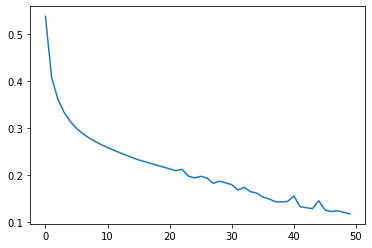

In [267]:
plt.plot(LL)

In [170]:
print('Минимальная ошибка', min(LL))
print('Лучший коэффициент', eta[LL.index(min(LL))])

Минимальная ошибка 0.11763259513737423
Лучший коэффициент 4.901


Чем больше итераций, тем меньше становится ошибка при оптимальном 4.9, однако скорость выполнения вырастает в два раза, поэтому оптимальное кол-во итераций  можно считать между 500 и 1000

**3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).**

In [171]:
def eval_model_w(X, y, iterations, eta=1.6):
    np.random.seed(42)
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    for i in range(iterations):
        z = np.dot(X, W)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        
        dQ = 1/n * X.T @ (y_pred - y)
        W -= eta * dQ
    return W

In [210]:
def calc_pred_proba(X, W):
    p_1 = 1/(1+np.exp(np.dot(X, W)))
    return p_1.round(2)

In [211]:
W = eval_model_w(X_st, y, 600, 4.9)

W

array([-31.99273388,  -3.28408755,  -8.56503054,  26.39092781])

In [212]:
p = calc_pred_proba(X_st, W)

p

array([0.62, 0.98, 0.  , 1.  , 0.07, 0.92, 0.  , 0.98, 0.4 , 0.  ])

Cтолбец — это вероятность того, что на выходе результат будет единица или p(x).
Также можно добавить столбец 1-p(x) — вероятность того, что прогнозируемый результат будет равен нулю/

**4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).**

In [219]:
def calc_pred(X, W):
    m = X.shape[0]
    p = calc_pred_proba(X, W)
    y_pred = np.zeros(m)
    
    # За порог отнесения к тому или иному классу примем вероятность 0.5
    for i in range(p.shape[0]):
        if (p[i] <= 0.5): 
            y_pred[i] = 1
        elif (p[i] > 0.5):
            y_pred[i] = 0

    return y_pred

In [220]:
y_p = calc_pred(X_st, W)

y_p

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 1.])

**5* Реализуйте функции для подсчета Accuracy, матрицы ошибок, точности и полноты, а также F1 score.**

In [222]:
def calc_accuracy(X, W, y):
    y_pred = calc_pred(X, W)
    calc_accuracy = np.mean(y_pred == y) * 100.0
    return calc_accuracy

In [223]:
calc_accuracy(X_st, W, y)

100.0

In [235]:
def matrix_error(y, y_pred):
    k = 0
    matrix_error = []
    for i in y_pred:
        if i == 0 and y[k] == 0:
            matrix_error.append('TP')
        elif i == 1 and y[k] == 0:
            matrix_error.append('FP')
        elif i == 0 and y[k] == 1:
            matrix_error.append('FN')            
        elif i == 1 and y[k] == 1:
            matrix_error.append('TN')            
        k +=1 
        
    return matrix_error

In [250]:
m_e = matrix_error(y, y_p)

m_e

['TP', 'TP', 'TN', 'TP', 'TN', 'TP', 'TN', 'TP', 'TN', 'TN']

In [257]:
def prec_recall_F(m_e):
    prec = m_e.count('TP')/(m_e.count('TP')+m_e.count('FP'))
    recall = m_e.count('TP')/(m_e.count('TP')+m_e.count('FN'))
    F = (2*prec*recall)/(prec+recall)
    
    return prec, recall, F

#F меру также можно через усовершенствованную функцию с коэффициентом b: (1+b^2)/b^2

In [256]:
prec_recall_F(m_e)

(1.0, 1.0, 1.0)

**6. Могла ли модель переобучиться? Почему?**

Также как и в линейной/полиномиальной регрессии, если мы усложним коэффициенты модели, сделаем точную подгонку, то на тестовых данных она может не работать, т.к. "переобучится".
Например, было 2-3 "выброса", усложнением мы построили такую "границу", что она "обошла" эти выбросы и точно предсказала все данные на тренинговой выборке, но на тестовой стала показывать странные результаты ("граница" должна была быть другой менее сложной).